In [1]:
from planetHole import planetHole

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import glob
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pickle

In [50]:
# progress bars
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# doing zero injection reduction to find rough pos to start flux parameter exploration
ph = planetHole('../forwardModel/data/18May15/Ha', 'test_pa'+str(0)+'sep'+str(0), 'output', 0, 10, 110,
                fwhm=4.49, ghostpath='ghost.fits', highpass=False,
                klipparams=[6, 4, [20]], usegaussian=True)
ph.run_KLIP()
path = str(ph.get_result(2))

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)
KLIP result is saved to: output\test_pa0sep0-KLmodes-all.fits
result dir is output\test_pa0sep0-KLmodes-all.fits


grabbing output/test_pa0sep0-KLmodes-all.fits

residual for output\test_pa0sep0-KLmodes-all.fits is -7056.1455



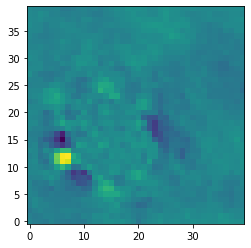

In [6]:
print('grabbing '+'output/test_pa0sep0-KLmodes-all.fits')
with fits.open(path) as img:
    im = img[1].data[0]
    plt.imshow(im[210:250,210:250], origin='lower')
residual = np.sum(im[210:230,205:225])
print('')
print('residual for '+path+' is '+str(residual))
print('')

In [62]:
fluxes = np.arange(-450,-900,-50)
len(fluxes)

9

In [63]:
# do flux parameter exploration
print(fluxes)
flux_resids = np.zeros(len(fluxes))
for i in tqdm(range(len(fluxes))):
    flux = fluxes[i]
    ph = planetHole('datum0', 'test_flux'+str(flux), 'output', flux, 9.66, 110.3,
                    fwhm=3, ghostpath='ghost.fits', highpass=False,
                    klipparams=[6, 4, [20]], usegaussian=True)
    ph.run_KLIP()
    path = str(ph.get_result(2))
    print('grabbing '+path)
    with fits.open(path) as img:
        im = img[1].data[0]
    residual = np.nansum(im[210:230,205:225]**2)
    print('')
    print('residual for '+path+' is '+str(residual))
    print('')
    flux_resids[i] += residual
    

[-450 -500 -550 -600 -650 -700 -750 -800 -850]


reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)
KLIP result is saved to: output\test_flux-450-KLmodes-all.fits
result dir is output\test_flux-450-KLmodes-all.fits
grabbing output\test_flux-450-KLmodes-all.fits

residual for output\test_flux-450-KLmodes-all.fits is 1759415.4

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collap

In [73]:
paths = glob.glob('output/test_flux*.fits')
# paths = [paths[6]] + paths[0:6]
paths

['output\\test_flux-450-KLmodes-all.fits',
 'output\\test_flux-500-KLmodes-all.fits',
 'output\\test_flux-550-KLmodes-all.fits',
 'output\\test_flux-600-KLmodes-all.fits',
 'output\\test_flux-650-KLmodes-all.fits',
 'output\\test_flux-700-KLmodes-all.fits',
 'output\\test_flux-750-KLmodes-all.fits',
 'output\\test_flux-800-KLmodes-all.fits',
 'output\\test_flux-850-KLmodes-all.fits']

In [74]:
def trim_axs(axs, N):
    """conform the axs list to have correct length"""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

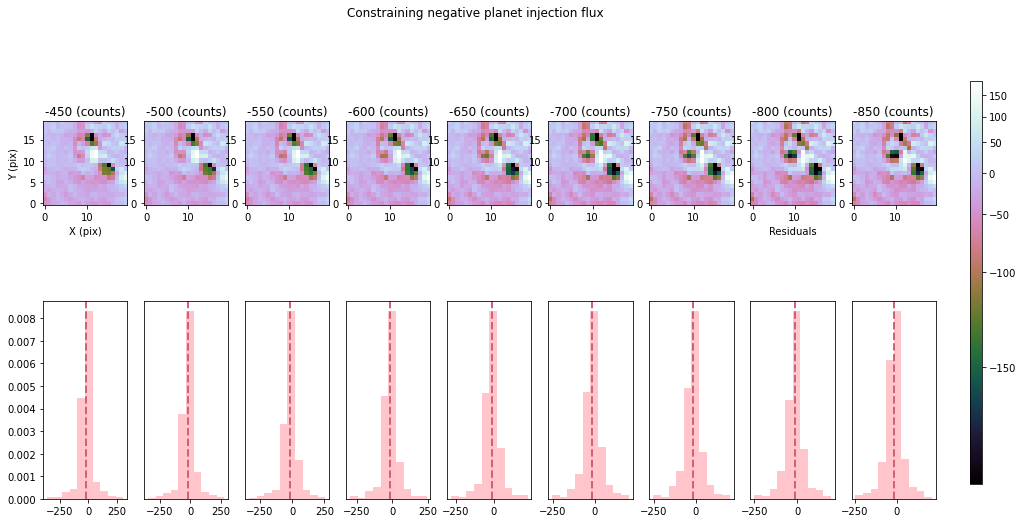

In [77]:
fig1, axs = plt.subplots(2, 9, figsize=(16,8))
axs = trim_axs(axs, 2*len(fluxes))

fig1.suptitle('Constraining negative planet injection flux')
axs[0].set_xlabel('X (pix)')
axs[0].set_ylabel('Y (pix)')

axs[7].set_xlabel('Residuals')

fluxes2 = fluxes.tolist()

for ax, i in zip(axs, range(len(axs))):
    if i < len(paths):
        path = paths[i]
        flux = fluxes2[i]
        ax.set_title('%s (counts)' % str(flux))
        with fits.open(path) as img:
            im = img[1].data[0]
            stamp = im[210:230,205:225]
            axis = ax.imshow(stamp, origin='lower', norm=ImageNormalize(stamp, stretch=AsinhStretch(), vmin=-0.9*np.nanmax(stamp), vmax=0.9*np.nanmax(stamp)), cmap='cubehelix')
    else:
        j = i-(int(len(axs)/2))
        path = paths[j]
        flux = fluxes2[j]
        with fits.open(path) as img:
            im = img[1].data[0]
            stamp = im[210:230,205:225]
            vals = stamp.flatten()
            ax.hist(vals, density=True, color='xkcd:light rose')
            ax.axvline(x=np.nanmedian(vals), color='xkcd:rose', linestyle='dashed', linewidth=2)
            
        if i > len(paths):
            ax.get_yaxis().set_visible(False)

cbar_ax = fig1.add_axes([0.93, 0.15, 0.01, 0.7])
fig1.colorbar(axis, cax=cbar_ax)
plt.savefig('negativeplanet_flux_fine.png', dpi=200)

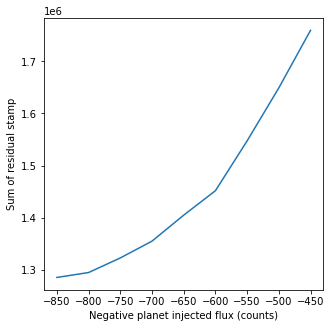

In [72]:
plt.figure(figsize=(5,5))
plt.plot(fluxes, flux_resids)
plt.xlabel('Negative planet injected flux (counts)')
# plt.xlim(-950,-1250)
plt.ylabel('Sum of residual stamp')
plt.savefig('sumvsflux.png', dpi=200)

In [22]:
# param_space = np.zeros((len(range(109,111)), len(range(9,11))))
# for pa in tqdm(range(109,111)):
#     for sep in range(9,11):
#         ph = planetHole('datum0', 'test_pa'+str(pa)+'sep'+str(sep), 'output', -1000, sep, pa,
#                  fwhm=3, ghostpath='ghost.fits', highpass=False,
#                  klipparams=[6, 3, [1, 5, 50]], usegaussian=True)
#         ph.run_KLIP()
#         path = str(ph.get_result(2))
#         print('grabbing '+path)
#         with fits.open(path) as img:
#             im = img[1].data[2]
#         residual = np.nansum(im[210:230,205:225])
#         print('')
#         print('residual for '+path+' is '+str(residual))
#         print('')
#         param_space[pa-109,sep-9] += residual

# print(param_space)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(3, 153, 1, 451, 451)
KLIP result is saved to: output\test_pa109sep9-KLmodes-all.fits
result dir is output\test_pa109sep9-KLmodes-all.fits
grabbing output\test_pa109sep9-KLmodes-all.fits

residual for output\test_pa109sep9-KLmodes-all.fits is -748.41315

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength c

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:39<02:39, 159.55s/it]

KLIP result is saved to: output\test_pa109sep10-KLmodes-all.fits
result dir is output\test_pa109sep10-KLmodes-all.fits
grabbing output\test_pa109sep10-KLmodes-all.fits

residual for output\test_pa109sep10-KLmodes-all.fits is -949.6642

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(3, 153, 1, 451, 451)
KLIP result is saved to: output\test_pa110sep9-KLmodes-all.fits
result dir is output\test_pa110sep9-KLmodes-all.fits
grabbing output\test_pa110sep9-KLmodes-all.fits

residual for output\test_pa110sep9-KLmodes-all.fits is -614.4364

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has 

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [05:15<00:00, 157.60s/it]

KLIP result is saved to: output\test_pa110sep10-KLmodes-all.fits
result dir is output\test_pa110sep10-KLmodes-all.fits
grabbing output\test_pa110sep10-KLmodes-all.fits

residual for output\test_pa110sep10-KLmodes-all.fits is -871.4548

[[-748.41314697 -949.66418457]
 [-614.43640137 -871.45477295]]


In [29]:
pas = np.arange(110.,111.25,0.25)
seps = np.arange(8.75,9.75,0.25)
n = len(pas)*len(seps)
print(pas)
print(seps)
print(n)

[110.   110.25 110.5  110.75 111.  ]
[8.75 9.   9.25 9.5 ]
20


In [30]:
param_space = np.zeros((len(pas), len(seps)))
sortedpaths = []
for i in tqdm(range(len(pas))):
    pa = pas[i]
    for j in tqdm(range(len(seps))):
        sep = seps[j]
        ph = planetHole('datum0', 'test_pa'+str(pa)+'sep'+str(sep), 'output', -1000, sep, pa,
                        fwhm=3, ghostpath='ghost.fits', highpass=False,
                        klipparams=[6, 3, [50]], usegaussian=True)
        ph.run_KLIP()
        path = str(ph.get_result(0))
        print('grabbing '+path)
        with fits.open(path) as img:
            im = img[1].data[0]
        sortedpaths.append(path)
        sumsqresidual = np.nansum(im[210:230,205:225]**2)
        print('')
        print('residual for '+path+' is '+str(sumsqresidual))
        print('')
        param_space[i,j] += sumsqresidual

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 25%|█████████████████████                                                               | 1/4 [01:27<04:21, 87.19s/it]

KLIP result is saved to: output\test_pa110.0sep8.75-KLmodes-all.fits
result dir is output\test_pa110.0sep8.75-KLmodes-all.fits
grabbing output\test_pa110.0sep8.75-KLmodes-all.fits

residual for output\test_pa110.0sep8.75-KLmodes-all.fits is 620727.56

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 50%|██████████████████████████████████████████                                          | 2/4 [02:25<02:36, 78.50s/it]

KLIP result is saved to: output\test_pa110.0sep9.0-KLmodes-all.fits
result dir is output\test_pa110.0sep9.0-KLmodes-all.fits
grabbing output\test_pa110.0sep9.0-KLmodes-all.fits

residual for output\test_pa110.0sep9.0-KLmodes-all.fits is 549367.5

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:22<01:12, 72.10s/it]

KLIP result is saved to: output\test_pa110.0sep9.25-KLmodes-all.fits
result dir is output\test_pa110.0sep9.25-KLmodes-all.fits
grabbing output\test_pa110.0sep9.25-KLmodes-all.fits

residual for output\test_pa110.0sep9.25-KLmodes-all.fits is 556405.75

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa110.0sep9.5-KLmodes-all.fits
result dir is output\test_pa110.0sep9.5-KLmodes-all.fits
grabbing output\test_pa110.0sep9.5-KLmodes-all.fits

residual for output\test_pa110.0sep9.5-KLmodes-all.fits is 622174.25

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 25%|█████████████████████                                                               | 1/4 [00:57<02:53, 57.82s/it]

KLIP result is saved to: output\test_pa110.25sep8.75-KLmodes-all.fits
result dir is output\test_pa110.25sep8.75-KLmodes-all.fits
grabbing output\test_pa110.25sep8.75-KLmodes-all.fits

residual for output\test_pa110.25sep8.75-KLmodes-all.fits is 603149.25

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 50%|██████████████████████████████████████████                                          | 2/4 [01:55<01:55, 57.93s/it]

KLIP result is saved to: output\test_pa110.25sep9.0-KLmodes-all.fits
result dir is output\test_pa110.25sep9.0-KLmodes-all.fits
grabbing output\test_pa110.25sep9.0-KLmodes-all.fits

residual for output\test_pa110.25sep9.0-KLmodes-all.fits is 529539.6

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:53<00:57, 57.86s/it]

KLIP result is saved to: output\test_pa110.25sep9.25-KLmodes-all.fits
result dir is output\test_pa110.25sep9.25-KLmodes-all.fits
grabbing output\test_pa110.25sep9.25-KLmodes-all.fits

residual for output\test_pa110.25sep9.25-KLmodes-all.fits is 530471.44

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa110.25sep9.5-KLmodes-all.fits
result dir is output\test_pa110.25sep9.5-KLmodes-all.fits
grabbing output\test_pa110.25sep9.5-KLmodes-all.fits

residual for output\test_pa110.25sep9.5-KLmodes-all.fits is 599776.75

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 25%|█████████████████████                                                               | 1/4 [00:57<02:52, 57.45s/it]

KLIP result is saved to: output\test_pa110.5sep8.75-KLmodes-all.fits
result dir is output\test_pa110.5sep8.75-KLmodes-all.fits
grabbing output\test_pa110.5sep8.75-KLmodes-all.fits

residual for output\test_pa110.5sep8.75-KLmodes-all.fits is 583560.1

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 50%|██████████████████████████████████████████                                          | 2/4 [01:55<01:55, 57.64s/it]

KLIP result is saved to: output\test_pa110.5sep9.0-KLmodes-all.fits
result dir is output\test_pa110.5sep9.0-KLmodes-all.fits
grabbing output\test_pa110.5sep9.0-KLmodes-all.fits

residual for output\test_pa110.5sep9.0-KLmodes-all.fits is 517032.84

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:53<00:57, 57.72s/it]

KLIP result is saved to: output\test_pa110.5sep9.25-KLmodes-all.fits
result dir is output\test_pa110.5sep9.25-KLmodes-all.fits
grabbing output\test_pa110.5sep9.25-KLmodes-all.fits

residual for output\test_pa110.5sep9.25-KLmodes-all.fits is 514518.84

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa110.5sep9.5-KLmodes-all.fits
result dir is output\test_pa110.5sep9.5-KLmodes-all.fits
grabbing output\test_pa110.5sep9.5-KLmodes-all.fits

residual for output\test_pa110.5sep9.5-KLmodes-all.fits is 586657.9

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 25%|█████████████████████                                                               | 1/4 [00:59<02:58, 59.40s/it]

KLIP result is saved to: output\test_pa110.75sep8.75-KLmodes-all.fits
result dir is output\test_pa110.75sep8.75-KLmodes-all.fits
grabbing output\test_pa110.75sep8.75-KLmodes-all.fits

residual for output\test_pa110.75sep8.75-KLmodes-all.fits is 571420.5

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 50%|██████████████████████████████████████████                                          | 2/4 [01:59<01:58, 59.48s/it]

KLIP result is saved to: output\test_pa110.75sep9.0-KLmodes-all.fits
result dir is output\test_pa110.75sep9.0-KLmodes-all.fits
grabbing output\test_pa110.75sep9.0-KLmodes-all.fits

residual for output\test_pa110.75sep9.0-KLmodes-all.fits is 508659.94

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:59<00:59, 59.75s/it]

KLIP result is saved to: output\test_pa110.75sep9.25-KLmodes-all.fits
result dir is output\test_pa110.75sep9.25-KLmodes-all.fits
grabbing output\test_pa110.75sep9.25-KLmodes-all.fits

residual for output\test_pa110.75sep9.25-KLmodes-all.fits is 501275.25

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

KLIP result is saved to: output\test_pa110.75sep9.5-KLmodes-all.fits
result dir is output\test_pa110.75sep9.5-KLmodes-all.fits
grabbing output\test_pa110.75sep9.5-KLmodes-all.fits

residual for output\test_pa110.75sep9.5-KLmodes-all.fits is 574470.25

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 25%|█████████████████████                                                               | 1/4 [00:59<02:59, 59.88s/it]

KLIP result is saved to: output\test_pa111.0sep8.75-KLmodes-all.fits
result dir is output\test_pa111.0sep8.75-KLmodes-all.fits
grabbing output\test_pa111.0sep8.75-KLmodes-all.fits

residual for output\test_pa111.0sep8.75-KLmodes-all.fits is 566210.8

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 50%|██████████████████████████████████████████                                          | 2/4 [01:59<01:59, 59.92s/it]

KLIP result is saved to: output\test_pa111.0sep9.0-KLmodes-all.fits
result dir is output\test_pa111.0sep9.0-KLmodes-all.fits
grabbing output\test_pa111.0sep9.0-KLmodes-all.fits

residual for output\test_pa111.0sep9.0-KLmodes-all.fits is 504974.88

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:58<00:59, 59.46s/it]

KLIP result is saved to: output\test_pa111.0sep9.25-KLmodes-all.fits
result dir is output\test_pa111.0sep9.25-KLmodes-all.fits
grabbing output\test_pa111.0sep9.25-KLmodes-all.fits

residual for output\test_pa111.0sep9.25-KLmodes-all.fits is 496409.6

reading data, num files:  153
Begin align and scale images for each wavelength
Wavelength 0.656 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 6
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\willi\Amherst\Thesis\Code\diskShapers\planetHole\output
wavelength collapsing reduced data of shape (b, N, wv, y, x):(1, 153, 1, 451, 451)



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [20:01<00:00, 240.33s/it]

KLIP result is saved to: output\test_pa111.0sep9.5-KLmodes-all.fits
result dir is output\test_pa111.0sep9.5-KLmodes-all.fits
grabbing output\test_pa111.0sep9.5-KLmodes-all.fits

residual for output\test_pa111.0sep9.5-KLmodes-all.fits is 567810.75



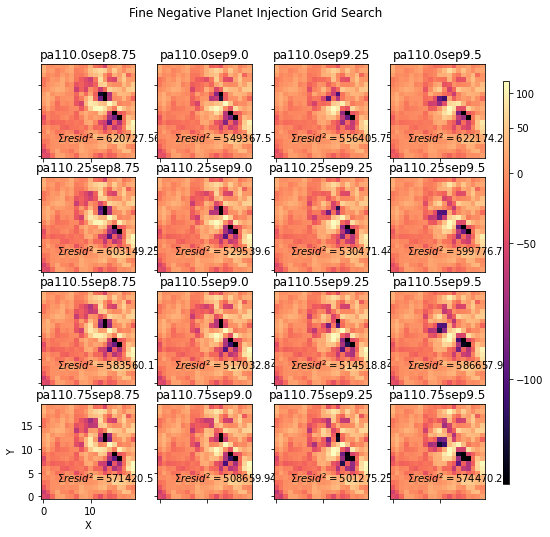

In [34]:
fig1, axs = plt.subplots(4, 4, figsize=(8,8))
axs = trim_axs(axs, len(sortedpaths))

fig1.suptitle('Fine Negative Planet Injection Grid Search')
labeli = 12
axs[labeli].set_xlabel('X')
axs[labeli].set_ylabel('Y')

for ax, i in zip(axs, range(len(sortedpaths))):
    path = sortedpaths[i]
    pref, suf = path.split('_')
    params, kl, suff = suf.split('-')
    ax.set_title(params)
    with fits.open(path) as img:
        im = img[1].data[0]
        stamp = im[210:230,205:225]
    axis = ax.imshow(stamp, origin='lower', norm = ImageNormalize(stamp, stretch=AsinhStretch(), vmin=-0.9*np.nanmax(stamp), vmax=0.9*np.nanmax(stamp)), cmap='magma')
    sumsqresidual = np.nansum(stamp**2)
    residlabel = r'$\Sigma resid^2 =$'+str(sumsqresidual)
    ax.annotate(xy=(3,3), text=residlabel)
    if i != labeli:
        ax.set(yticklabels=[],xticklabels=[])

cbar_ax = fig1.add_axes([0.93, 0.15, 0.01, 0.7])
fig1.colorbar(axis, cax=cbar_ax)
plt.savefig('negplanet_position_iteration_fine')

In [35]:
print(pas)
print(seps)

[110.   110.25 110.5  110.75 111.  ]
[8.75 9.   9.25 9.5 ]


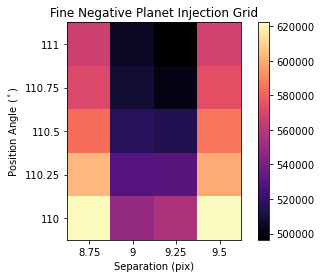

In [39]:
fig, ax = plt.subplots()
im = ax.imshow(param_space, cmap='magma', origin='lower')
ax.set(yticklabels=['','110','110.25','110.5', '110.75','111'],
       ylabel=r'Position Angle ($^\circ$)',
       xticklabels=['','8.75','9','9.25','9.5'],
       xlabel=r'Separation (pix)')
cbar = fig.colorbar(im)
plt.title('Fine Negative Planet Injection Grid')
plt.savefig('finegrid.png',dpi=200)

In [49]:
import pandas as pd
pd.DataFrame(param_space, columns=seps, index=pas)

,8.75,9.00,9.25,9.50
110.00,620727.5625,549367.50000,556405.75000,622174.250
110.25,603149.2500,529539.62500,530471.43750,599776.750
110.50,583560.1250,517032.84375,514518.84375,586657.875
110.75,571420.5000,508659.93750,501275.25000,574470.250
111.00,566210.8125,504974.87500,496409.59375,567810.750
